<a href="https://colab.research.google.com/github/iitianpushkar/Schrodinger_PINN_Solution_PyTorch/blob/main/Schrodinger_PINN_Solution_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [500/5000], Loss: 0.000000
Epoch [1000/5000], Loss: 0.000000
Epoch [1500/5000], Loss: 0.000000
Epoch [2000/5000], Loss: 0.000000
Epoch [2500/5000], Loss: 0.000000
Epoch [3000/5000], Loss: 0.000000
Epoch [3500/5000], Loss: 0.000000
Epoch [4000/5000], Loss: 0.000000
Epoch [4500/5000], Loss: 0.000000
Epoch [5000/5000], Loss: 0.000000


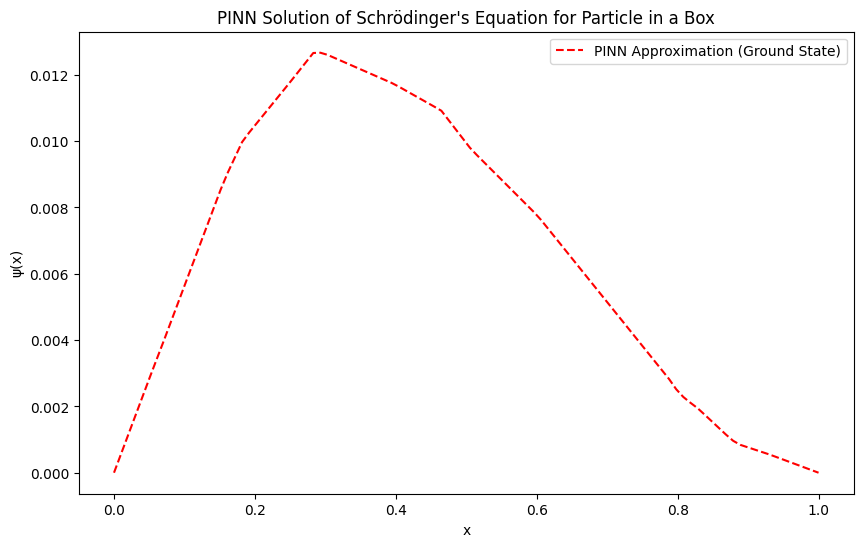

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Constants
hbar = 1.0  # Reduced Planck's constant
m = 1.0     # Mass of particle
L = 1.0     # Length of the box

# Define the domain (inside the box)
x = np.linspace(0, L, 100).reshape(-1, 1)
x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)

# Neural Network to approximate psi(x)
class SchrodingerPINN(nn.Module):
    def __init__(self):
        super(SchrodingerPINN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the physics-informed loss function
def pinn_loss(model, x, hbar=1.0, m=1.0):
    psi = model(x)

    # First derivative of psi
    psi_x = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

    # Second derivative of psi
    psi_xx = torch.autograd.grad(psi_x, x, grad_outputs=torch.ones_like(psi_x), create_graph=True)[0]

    # Schrodinger equation: - (hbar^2 / 2m) d^2ψ/dx^2 = Eψ (for a particle in a box, V(x) = 0)
    schrodinger_eq = -(hbar**2 / (2 * m)) * psi_xx

    # Boundary conditions: psi(0) = psi(L) = 0
    bc_left = model(torch.tensor([[0.0]]))  # psi(0)
    bc_right = model(torch.tensor([[L]]))   # psi(L)

    # Total loss is the PDE loss + boundary condition loss
    loss_pde = torch.mean(schrodinger_eq**2)
    loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)

    return loss_pde + loss_bc

# Initialize the neural network model
model = SchrodingerPINN()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, x_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

# Prediction using the trained model
y_pred = model(x_tensor).detach().numpy()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x, y_pred, label="PINN Approximation (Ground State)", color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("PINN Solution of Schrödinger's Equation for Particle in a Box")
plt.legend()
plt.show()



